### 2. Data quality check

* **Libraries import and default configuration.**

In [1]:
import os
import time
import math
import requests
import datetime
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings('ignore')

plotColor = ['b','g','r','m','y', 'silver', 'cadetblue', 
             'yellowgreen', 'darksalmon']

print('Libraries imported and default configurations set!')

Libraries imported and default configurations set!


* **Classes definition**

To see the classes documentation, please click [here](myData/classHelp.txt)

In [2]:
class aemetApi():
    
    ''' Class that conects to the AEMET API and retrieves the data '''
    
    def __init__(self, mainUrl, testUrl, header, urlKeyFile):
        
        self.mainUrl = mainUrl
        self.header = header
        self.testUrl = mainUrl + testUrl
        self.apiKey = self.getKey(urlKeyFile)
        self.testApi(self.testUrl, self.header, self.apiKey)
        
    def getKey(self, file):
        f = open(file, 'r')
        Key = f.read()
        Key = {'api_key': Key}
        return Key
    
    def testApi(self, url, header, queryS):
        testCall = self.getResponse(url, header, queryS)
        try:
            jsonResponse = testCall.json()
            if jsonResponse['estado'] == 200 : 
                print('Connection with AEMET api successfully tested')
            else:
                print('Connection with AEMET api test failed!')
                print(jsonResponse.text)
        except:
            print('Connection with AEMET api test failed!')
            print('Error response:\n\n' + testCall.text)
    
    def getResponse(self, url, header, queryS):
        response = requests.request("GET", url, headers=header, params=queryS)
        return response
    
    def getJson(self, url, header, queryS):
        resp = self.getResponse(url, header, queryS) 
        return resp.json()

In [3]:
class dataHandler():
    
    ''' Class that loads, checks and transform data '''
    
    def __init__(self):
        self.fullDF = pd.DataFrame()
        self.fullDF_Min = pd.DataFrame()
        self.fullDF_Max = pd.DataFrame()
        self.minDF = pd.DataFrame()
        self.maxDF = pd.DataFrame()
        self.minTrain = pd.Series()
        self.minTest = pd.Series()
        self.maxTrain = pd.Series()
        self.maxTest = pd.Series()
        self.lstDF = []
        self.lstName = ['Min. Temp', 'Max. Temp']
        self.yearIni = '-01-01T00:00:00UTC'
        self.yearEnd = '-12-31T00:00:00UTC'
    
    def getData(self, query, paramList, years, cols, colsN):
        cont = years[0]
        first = True
        yearRange = self.dataRange(np.arange(years[0], years[1]))
        statCode = '3129'
        for tpl in yearRange:
            if cont % 10 == 0 : print('Retrieving data for {}\'s decade...'.format(cont))
            cont += 1
            queryUrl = self.concatParams(query, paramList, [tpl[0], tpl[1], statCode]) 
            resp = API.getJson(API.mainUrl+queryUrl, API.header, API.apiKey) 
            yearData = API.getResponse(resp['datos'], API.header, API.apiKey) 
            self.addData(yearData.json(), first)
            time.sleep(1.5)
            first = False
        print('Data retrieved from AEMET API, splitting data...')    
        self.minDF, self.maxDF = self.processData()
        self.lstDF = [self.minDF, self.maxDF] 
        print('Dataframes for MADRID AEROPUERTO min./max. temperatures created. Checking data consistency...')
        self.checkAll(True)
    
    def checkAll(self, printI = False):
        i = 0
        strLine = '---------'
        print('\n### Checking time series ###\n')
        for df in self.lstDF:
            if i > 0 : print('\n')
            print('{}\n{}\n{}\n'.format(strLine, self.lstName[i], strLine))
            if printI : self.printInfo(df)
            self.printShape(df)
            idx = self.checkNaN(df)
            if len(idx) > 0:
                self.updateNaN(df,idx)
            i+=1

    def updateNaN(self, df, idx, avg = True):
        for temp in idx:
            for ind in temp[1]:
                meanMonth = str(ind.year) + '-' + str(ind.month)
                if avg : 
                    df[temp[0]].loc[ind] = df[temp[0]].loc[meanMonth].mean()
                else:
                    df[temp[0]].loc[ind] = df[temp[0]].loc[meanMonth].median()
        print('NaN values updated with aggregation values')
        
    def printShape(self, df):
        print('Dataframe shape\n---------------')
        print('{}\n'.format(df.shape))

    def printInfo(self, df):
        print('Dataframe information\n---------------------')
        print('{}\n'.format(df.info()))

    def checkNaN(self, df):
        lstIdx = []
        print('Nan check\n---------')
        for col in list(df.columns):
            nan = np.sum(df[col].isna().sum())
            print('{} NaN values in {} column'.format(nan, col))
            if nan > 0:
                lstIdx.append([col, df[np.isnan(df[col])].index])
        return lstIdx

    def addData(self, jsn, first):
        if first:
            self.fullDF = pd.DataFrame(jsn)
        else:
            tmpDF = pd.DataFrame(jsn)
            self.fullDF = self.fullDF.append(tmpDF, ignore_index = True)
    
    def processData(self):
        self.fullDF = self.fullDF[['fecha','tmin', 'tmax']]
        for col in ['tmin', 'tmax']:
            self.fullDF[col] = self.fullDF[col].str.replace(',','.')
            self.fullDF[col] = self.fullDF[col].apply(pd.to_numeric)
        self.fullDF_Min = self.fullDF[['fecha','tmin']].copy()
        self.fullDF_Min['fecha'] = self.fullDF_Min['fecha'].apply(pd.to_datetime)
        self.fullDF_Min.set_index('fecha', inplace = True)
        self.fullDF_Max = self.fullDF[['fecha','tmax']].copy()  
        self.fullDF_Max['fecha'] = self.fullDF_Max['fecha'].apply(pd.to_datetime)
        self.fullDF_Max.set_index('fecha', inplace = True)
        self.fullDF['tavg'] = (self.fullDF['tmax']+self.fullDF['tmin'])/2
        self.fullDF['fecha'] = self.fullDF['fecha'].apply(pd.to_datetime)
        self.fullDF.set_index('fecha', inplace = True)
        return self.fullDF_Min.resample('M').mean(), self.fullDF_Max.resample('M').mean()
    
    def dataRange(self, dataRange):
        lstYear = []
        for Anno in dataRange:
            lstYear.append((str(Anno)+self.yearIni, str(Anno)+self.yearEnd))
        return lstYear
    
    def concatParams(self, iniStr, lstParam, lstValues):
        params = iniStr
        for i in range(len(lstParam)):
            params = params+lstParam[i]+lstValues[i]
        return params

    def lstToStr(self, lst, sep = ','):  
        return (sep.join(lst)) 
    
    def describeAll(self):
        first = ''
        for df, name in zip(self.lstDF, self.lstName):
            print('{}### {} statistics ###\n'.format(first, name))
            print(df.describe().transpose().iloc[:,1:])
            first = '\n'
    
    def adFullerTest(self, df, name):
        strDash = '-----------------'
        strStat = 'The data IS stationary with'
        strNonStat = 'The data IS NOT stationary with'
        strConf = 'of confidence.'
        dctPerc = {'1%' : '99%', '5%' : '95%', '10%' : '90%'}
        print('### Augmented Dickey-Fuller test for {} series ###\n'.format(name))
        res = adfuller(df)
        print('Test Statistic = {:.5}'.format(res[0]))
        print('p-value = {:.5}'.format(res[1]))
        print('# of lags = {}'.format(res[2]))
        print('# of Observations used = {}'.format(res[3]))
        print('\n{}\n Critical values \n{}'.format(strDash, strDash))
        for key, value in res[4].items():
            if res[0] < value :
                print('{} = {:.5} - {} {} {}'.format(key, value, strStat, 
                                                     dctPerc[key], strConf))
            else:
                print('{} = {:.5} - {} {} {}'.format(key, value, strNonStat, 
                                                     dctPerc[key], strConf))
    
    def getIndValue(self, df, col, Format, Min = False, Max = False):
        if Min == Max:
            raise ValueError('Min. and Max. parameters cannot have the same value')
        if Min :
            Idx = df[col].idxmin().strftime(Format)
            Value = df[col].min()
        else:
            Idx = df[col].idxmax().strftime(Format)
            Value = df[col].max()

        return Idx, Value
    
    def printFacts(self, df):
        print('{}\n### DATA FROM {}-{} PERIOD ###\n{}\n'.format('#'*34,str(yearRange[0]),
                                                              str(yearRange[1]), '#'*34))
        self.printDaily(data.fullDF)
        self.printMonthly(data.fullDF.resample('M').mean())
        self.printYearly(data.fullDF.resample('Y').mean())
        
    def printDaily(self, df):
        print('### DAILY DATA ###\n')
        Idx, Value = self.getIndValue(df, 'tmin', '%d %B, %Y', Min = True)
        print('Min. daily temperature  --> {} ({}°C)'.format(Idx, Value))
        Idx, Value = self.getIndValue(df, 'tmax', '%d %B, %Y', Max = True)
        print('Max. daily temperature  --> {} ({}°C)'.format(Idx, Value))
        Idx, Value = self.getIndValue(df, 'tmin', '%d %B, %Y', Max = True)
        print('Warmest min. daily temperature  --> {} ({}°C)'.format(Idx, Value))
        Idx, Value = self.getIndValue(df, 'tmax', '%d %B, %Y', Min = True)
        print('Coldest max. daily temperature  --> {} ({}°C)\n'.format(Idx, Value))
        
    def printMonthly(self, df):
        print('### MONTHLY DATA ###\n')
        Idx, Value = self.getIndValue(df, 'tmin', '%B, %Y', Min = True)
        print('Min. monthly average temperature  --> {} ({:.1f}°C)'.format(Idx, Value))
        Idx, Value = self.getIndValue(df, 'tmax', '%B, %Y', Max = True)
        print('Max. monthly average temperature  --> {} ({:.1f}°C)'.format(Idx, Value))
        Idx, Value = self.getIndValue(df, 'tmin', '%B, %Y', Max = True)
        print('Warmest min. monthly average temperature  --> {} ({:.1f}°C)'.format(Idx, Value))
        Idx, Value = self.getIndValue(df, 'tmax', '%B, %Y', Min = True)
        print('Coldest max. monthly average temperature  --> {} ({:.1f}°C)\n'.format(Idx, Value))
       
    def printYearly(self, df):
        print('### YEARLY DATA ###\n')
        Idx, Value = self.getIndValue(df, 'tmin', '%Y', Min = True)
        print('Min. yearly average temperature  --> {} ({:.1f}°C)'.format(Idx, Value))
        Idx, Value = self.getIndValue(df, 'tmax', '%Y', Max = True)
        print('Max. yearly average temperature  --> {} ({:.1f}°C)'.format(Idx, Value))
        Idx, Value = self.getIndValue(df, 'tmin', '%Y', Max = True)
        print('Warmest min. yearly average temperature  --> {} ({:.1f}°C)'.format(Idx, Value))
        Idx, Value = self.getIndValue(df, 'tmax', '%Y', Min = True)
        print('Coldest max. yearly average temperature  --> {} ({:.1f}°C)'.format(Idx, Value))
        
    def monthName(self, intMonth):
        return datetime.date(1900, intMonth, 1).strftime('%B')

In [42]:
class plotGraph:
    
    '''Class that draw plots'''
    
    def __init__(self):
        self.setStyle()

    def setStyle(self, style = 'darkgrid'):
        sns.set(style = style)
    
    def plotLine(self, df, fig, xLbl, yLbl, title, titleFS= 15, lblFS = 12, ticksFS = 10, 
                 showL = True, lineW = 1, plotC = 'b', rollMean = False, rollSTD = False):

        plt.plot(df, color = plotC, linewidth = lineW, label = 'Mean monthly temperature')
        if rollMean:
            plt.plot(df.rolling(window=12).mean(), color = plotColor[2], 
                     linewidth = lineW, label = 'Rolling mean')
        if rollSTD:
            plt.plot(df.rolling(window=12).std(), color = plotColor[3], 
                     linewidth = lineW, label = 'Rolling STD')
            
        xTicks = [str(x)+'-01-01' for x in np.arange(yearRange[0], yearRange[1]+1,2)]
        yTicks = np.arange(math.floor(df.min()), math.ceil(df.max())+2,2)
        xTicksL = np.arange(yearRange[0], yearRange[1]+1,2)
        plt.xlabel(xLbl, fontsize = lblFS)
        plt.ylabel(yLbl, fontsize = lblFS)
        plt.title(title, fontsize = titleFS)
        plt.xticks(xTicks, fontsize = ticksFS)
        fig.set_xticklabels(xTicksL)
        plt.yticks(yTicks, fontsize = ticksFS)
        plt.tick_params(top=False, bottom=True, left=True, right=False,
                        labelleft=True, labelbottom=True)
        if showL:
            plt.legend(bbox_to_anchor=([1.015,1]), frameon = False)
    
    def plotDecom(self, df, name, fig, freq, titleFS = 15, plotC = 'b'):
    
        decomp_res = seasonal_decompose(df, freq = freq)
        decomp_res.trend.plot(ax=ax1, color = plotC)
        ax1.set_ylabel('Trend')
        ax1.set_xlabel('')
        ax1.set_title(name, fontsize = titleFS)
        decomp_res.seasonal.plot(ax=ax2, color = plotC)
        ax2.set_ylabel('Seasonality')
        ax2.set_xlabel('')
        decomp_res.resid.plot(ax=ax3, color = plotC)
        ax3.set_ylabel('Residuals')
        ax3.set_xlabel('')
        plt.tight_layout()
        
    def plotACF(self, df, name, fig, lag = 12):
        plot_acf(df, lags = lag, zero=False, ax=ax)
        ax.set_xlabel('Lag') 
        ax.set_xticks(np.arange(0,25,2))
        ax.set_title(name + ' Autocorrelation', fontsize = 17)
        plt.tight_layout()

    def plotDiag(self, ARIMA, variable=0, lags=10, fig=None, figsize=None):
        return type(ARIMA.plot_diagnostics(variable, lags, fig, figsize))
    
    def plotForecast(self, prev, true, pred, confI, fig, xLbl, yLbl, title, titleFS= 15, 
                     lblFS = 12, ticksFS = 10, showL = True, lineW = 1, 
                     plotC = ['b', 'orange', 'r']):

        plt.plot(prev, color = plotC[0], linewidth = lineW, label = 'Series values')
        plt.plot(true, color = plotC[1], linewidth = lineW, label = 'Test values')
        plt.plot(pred, color = plotC[2], linewidth = lineW, linestyle=':',
                 label = 'Predicted values')
        plt.fill_between(pred.index, confI['lower'], confI['upper'], color = plotC[2],
                         alpha = 0.25)
        yTicks = np.arange(math.floor(confI['lower'].min()-2), 
                           math.ceil(confI['upper'].max())+2,2)
        plt.xlabel(xLbl, fontsize = lblFS)
        plt.ylabel(yLbl, fontsize = lblFS)
        plt.title(title, fontsize = titleFS)
        plt.yticks(yTicks, fontsize = ticksFS)
        plt.tick_params(top=False, bottom=True, left=True, right=False,
                        labelleft=True, labelbottom=True)
        if showL:
            plt.legend(bbox_to_anchor=([1.015,1]), frameon = False)
    
    def plotPred(self, true, pred, confI, fig, xLbl, yLbl, title, titleFS= 15, 
                 lblFS = 12, ticksFS = 10, showL = True, lineW = 1, plotC = ['b', 'r']):

        plt.plot(true, color = plotC[0], linewidth = lineW, label = 'Series values')
        plt.plot(pred, color = plotC[1], linewidth = lineW, label = 'Predicted values')
        plt.fill_between(pred.index, confI['lower'], confI['upper'], color = plotC[1],
                         alpha = 0.25)
        yTicks = np.arange(math.floor(confI['lower'].min()-2), 
                           math.ceil(confI['upper'].max())+2,2)
        plt.xlabel(xLbl, fontsize = lblFS)
        plt.ylabel(yLbl, fontsize = lblFS)
        plt.title(title, fontsize = titleFS)
        plt.yticks(yTicks, fontsize = ticksFS)
        plt.tick_params(top=False, bottom=True, left=True, right=False,
                        labelleft=True, labelbottom=True)
        if showL:
            plt.legend(bbox_to_anchor=([1.015,1]), frameon = False)
        
    def plotBar(self, X, y, fig, barW, strTitle, yLbl, lstColor = ['b', 'r'], alpha = 0.65):

        barP = plt.bar(X, y, width = barW, alpha = alpha)
        plt.title(strTitle, fontsize = 15, fontweight = 450)
        plt.xlabel('')
        plt.ylabel(yLbl)
        plt.tick_params(top=False,bottom=True,left=True,right=False,labelleft=True,labelbottom=True)
        plt.grid(b=True)
        for bar in barP:
            if bar.get_height() > 0 :
                bar.set_color(lstColor[0])
            else:
                bar.set_color(lstColor[1])

In [5]:
class modelHandler():
    
    def __init__(self):
        self.modelMin = None
        self.modelMax = None
    
    def autoARIMA(self, df, txt1, txt2, name, seas = False, infC = 'aic', min_p = 0, min_q = 0,
                  max_p = 2, max_q = 2, d = None, m = 12, min_P = 0, min_Q = 0, max_P = 2,
                  max_Q = 2, D = None, trend = 'c', trace = False, first = False, rndST = 12):
    
        if not first: print('\n')
        print('{}{} {} {}\n'.format(txt1, txt2, name, txt2))
        res = pm.auto_arima(df, seasonal = seas, information_criterion = infC, min_p = min_p, 
                            min_q = min_q, max_p = max_p, max_q = max_q, d = d, m = m, 
                            min_P = min_P, min_Q = min_Q, max_P = max_P, max_Q = max_Q, D = D, 
                            trace = trace, error_action = 'ignore', suppress_warnings=True, 
                            random_state = rndST)
        return res

    def trainTestSplit(self, df, rangeTrain, rangeTest):
        train = df.loc[:rangeTrain]
        test =  df.loc[rangeTest:]
        return train, test

    def fitForecast(self, mMin, mMax, Min, Max, MinT, MaxT, names):
        self.fitSARIMAX([mMin, mMax], [Min, Max])
        print('Models fitted, making forecast...')
        forMin, minCI = self.forecastConfInt(mMin, MinT, 'tmin')
        forMax, maxCI = self.forecastConfInt(mMax, MaxT, 'tmax')
        print('Forecast completed, plotting results...\n')
        self.getMAE([MinT, MaxT], [forMin, forMax], names)
        return [forMin, forMax], [minCI, maxCI]
       
            
    def fitSARIMAX(self, models, dfs):
        for model, df in zip(models, dfs):
            model.fit(df)

    def forecastConfInt(self, model, df, name):
        yPred, yConfInt = model.predict(n_periods=len(df), return_conf_int=True, alpha=0.05)
        yPred = pd.DataFrame(yPred, index=df.index, columns = [name])
        yConfInt = pd.DataFrame(yConfInt, index = df.index, columns = ['lower', 'upper'])
        return yPred, yConfInt
    
    def predictConfInt(self, model, periods, name):
        yPred, yConfInt = model.predict(n_periods=len(periods), return_conf_int=True, alpha=0.05)
        yPred = pd.DataFrame(yPred, index=periods, columns = [name])
        yConfInt = pd.DataFrame(yConfInt, index = periods, columns = ['lower', 'upper'])
        return yPred, yConfInt
    
    def getMAE(self, yTrue, yPred, names):
        for true, pred, name in zip(yTrue, yPred, names):
            MAE =mean_absolute_error(true, pred)
            print('{} forecast MAE --> {:.4f}'.format(name, MAE))
        print('\n')
        
    def predChange(self, lstPredDF, lstCols, lstColNames):
        lstDF = []
        diff = 0.0
        i = 0
        for df in lstPredDF:
            for m in range(12):
                j = 0
                mnth = datetime(1900,(m+1),1).strftime("%B")
                for temp in list(df[df.index.month == m+1][lstCols[i]]):
                    if j == 0 : diff = temp
                    if j == 4 : diff = temp - diff
                    j += 1
                lstDF.append([mnth[:3]+'.', diff])
            if i == 0 :
                df1 = pd.DataFrame(lstDF, columns = ['Month', lstColNames[i]])
                df1.set_index('Month', inplace=True)
                lstDF = []
            else:
                df2 = pd.DataFrame(lstDF, columns = ['Month', lstColNames[i]])
                df2.set_index('Month', inplace=True)
            i =+1
        finalDF = pd.concat([df1, df2], axis = 1)
        return finalDF

* **Data load, formatting, inspection and cleaning**

In [6]:
# Test AEMET API
API = aemetApi('https://opendata.aemet.es/opendata/api/valores/climatologicos/', 
                'inventarioestaciones/todasestaciones/',
              {'cache-control': 'no-cache'}, 'myData/aemetApi.txt')

Connection with AEMET api successfully tested


In [7]:
# Retrieve data from the AEMET site via API
data = dataHandler()
specQuery = 'diarios/datos/'
paramList = ['fechaini/', '/fechafin/', '/estacion/']
yearRange = [1990, 2020]
lstCols = ['fecha', 'tmin', 'tmax']
lstColsN = ['tmin', 'tmax']
data.getData(specQuery, paramList, yearRange, lstCols, lstColsN)

Retrieving data for 1990's decade...
Retrieving data for 2000's decade...
Retrieving data for 2010's decade...
Data retrieved from AEMET API, splitting data...
Dataframes for MADRID AEROPUERTO min./max. temperatures created. Checking data consistency...

### Checking time series ###

---------
Min. Temp
---------

Dataframe information
---------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 1990-01-31 to 2019-12-31
Freq: M
Data columns (total 1 columns):
tmin    360 non-null float64
dtypes: float64(1)
memory usage: 5.6 KB
None

Dataframe shape
---------------
(360, 1)

Nan check
---------
0 NaN values in tmin column


---------
Max. Temp
---------

Dataframe information
---------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 1990-01-31 to 2019-12-31
Freq: M
Data columns (total 1 columns):
tmax    360 non-null float64
dtypes: float64(1)
memory usage: 5.6 KB
None

Dataframe shape
---------------
(360, 1)

Nan check
---------

## 3. Descriptive statistics

* **General overview**

In [8]:
# Print basic statistics of the series
data.describeAll()

### Min. Temp statistics ###

          mean       std       min       25%       50%        75%        max
tmin  8.211317  6.147182 -3.848387  2.989516  7.346935  13.845833  20.748387

### Max. Temp statistics ###

           mean       std       min        25%        50%        75%  \
tmax  21.406766  8.198489  8.448387  13.784821  20.304483  29.154167   

            max  
tmax  37.090323  


In [9]:
# Print meaningful statistical data
data.printFacts(data.fullDF)

##################################
### DATA FROM 1990-2020 PERIOD ###
##################################

### DAILY DATA ###

Min. daily temperature  --> 16 December, 2001 (-10.5°C)
Max. daily temperature  --> 24 July, 1995 (42.2°C)
Warmest min. daily temperature  --> 19 August, 2012 (25.8°C)
Coldest max. daily temperature  --> 10 January, 2010 (0.5°C)

### MONTHLY DATA ###

Min. monthly average temperature  --> December, 2001 (-3.8°C)
Max. monthly average temperature  --> July, 2015 (37.1°C)
Warmest min. monthly average temperature  --> July, 2015 (20.7°C)
Coldest max. monthly average temperature  --> December, 2001 (8.4°C)

### YEARLY DATA ###

Min. yearly average temperature  --> 1992 (7.2°C)
Max. yearly average temperature  --> 2017 (23.0°C)
Warmest min. yearly average temperature  --> 2014 (9.7°C)
Coldest max. yearly average temperature  --> 1993 (19.9°C)


* **Data visualization**

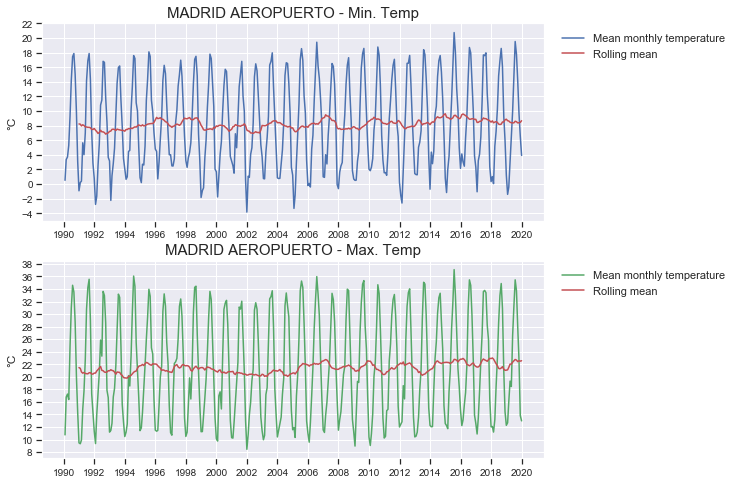

In [43]:
# Plot time series and rolling mean
pg = plotGraph()
fig1 = plt.figure(figsize=[9,8])
strTitle = ['MADRID AEROPUERTO - '+data.lstName[0], 
            'MADRID AEROPUERTO - '+data.lstName[1]]   

pg.plotLine(data.minDF, fig1.add_subplot(2,1,1), '', '°C', strTitle[0], lineW = 1.5, 
            rollMean = True)  
pg.plotLine(data.maxDF, fig1.add_subplot(2,1,2), '', '°C', strTitle[1], lineW = 1.5, 
            plotC = plotColor[1], rollMean = True)    

plt.show()

## 4. Exporatory data analysis

* **Augmented Dickey-Fuller test**

In [11]:
# Run Augmented Dickey-Fuller test on both DF
data.adFullerTest(data.minDF, data.lstName[0])
print('\n')
data.adFullerTest(data.maxDF, data.lstName[1])

### Augmented Dickey-Fuller test for Min. Temp series ###

Test Statistic = -3.4548
p-value = 0.0092276
# of lags = 11
# of Observations used = 348

-----------------
 Critical values 
-----------------
1% = -3.4493 - The data IS stationary with 99% of confidence.
5% = -2.8699 - The data IS stationary with 95% of confidence.
10% = -2.5712 - The data IS stationary with 90% of confidence.


### Augmented Dickey-Fuller test for Max. Temp series ###

Test Statistic = -3.947
p-value = 0.0017148
# of lags = 16
# of Observations used = 343

-----------------
 Critical values 
-----------------
1% = -3.4496 - The data IS stationary with 99% of confidence.
5% = -2.87 - The data IS stationary with 95% of confidence.
10% = -2.5713 - The data IS stationary with 90% of confidence.


* **Time series decomposition plots**

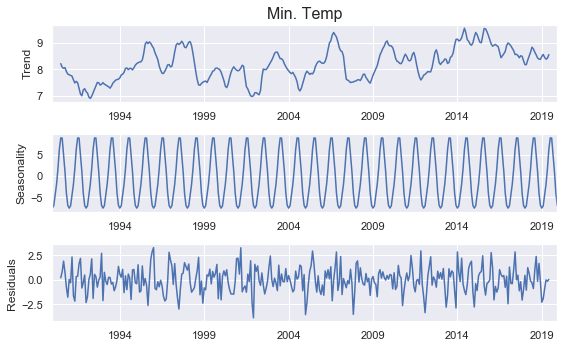

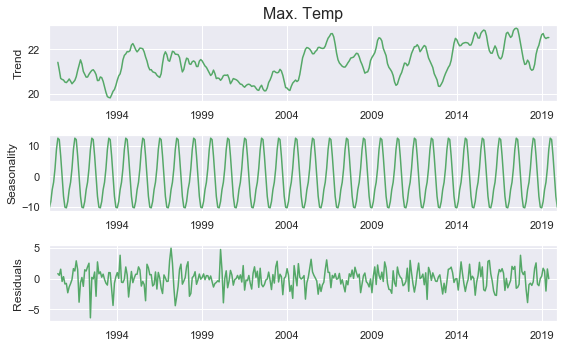

In [12]:
# Show decomposition plots
for df, name, color in zip([data.minDF, data.maxDF], data.lstName, plotColor[0:2]):
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(8,5))
    pg.plotDecom(df, name, fig, 12, titleFS = 16, plotC = color)

plt.show()

* **Autocorrelation plots**

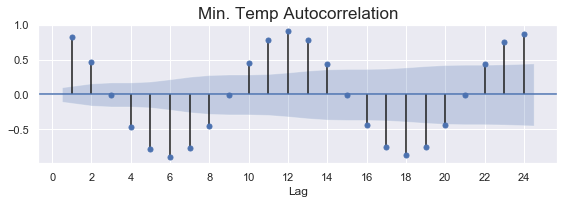

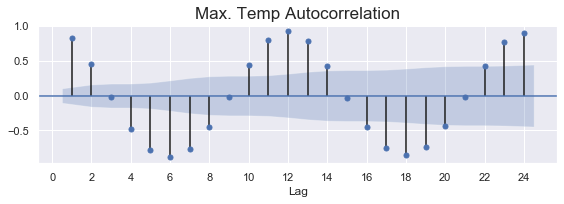

In [13]:
for df, name in zip([data.minDF, data.maxDF], data.lstName):
    fig, ax = plt.subplots(1,1,figsize=(8,3))
    pg.plotACF(df, name, fig, lag = 24)
plt.show()

## 6. Model development

* **Train/test series split**

In [14]:
# Initiate model handler object and slit series in train and test
modelH = modelHandler()
data.minTrain, data.minTest = modelH.trainTestSplit(data.minDF, '2014-12', '2015-01')
data.maxTrain, data.maxTest = modelH.trainTestSplit(data.maxDF, '2014-12', '2015-01')
print('Min./Max. series splitted in train/test series.')

Min./Max. series splitted in train/test series.


* **SARIMA order lookup**

In [15]:
# Find SARIMA orders for both series
space = '                           '
head = '#############'
modelH.modelMin = modelH.autoARIMA(data.minTrain, space, head, data.lstName[0], seas = True,
                                   infC = 'aic', max_p = 4, max_q = 4, m = 12, D = 1, max_P = 3,
                                   max_Q = 3, first = True)
print(modelH.modelMin.summary())
modelH.modelMax = modelH.autoARIMA(data.maxTrain, space, head, data.lstName[1], seas = True,
                                   max_P = 3, max_Q = 3, infC = 'aic', max_p = 4, max_q = 4, m = 12, 
                                   D = 1, first = False)
print(modelH.modelMax.summary())

                           ############# Min. Temp #############

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  300
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 12)   Log Likelihood                -518.330
Date:                              Wed, 25 Mar 2020   AIC                           1052.660
Time:                                      01:38:06   BIC                           1081.963
Sample:                                           0   HQIC                          1064.403
                                              - 300                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0540      0.032

matplotlib.figure.Figure

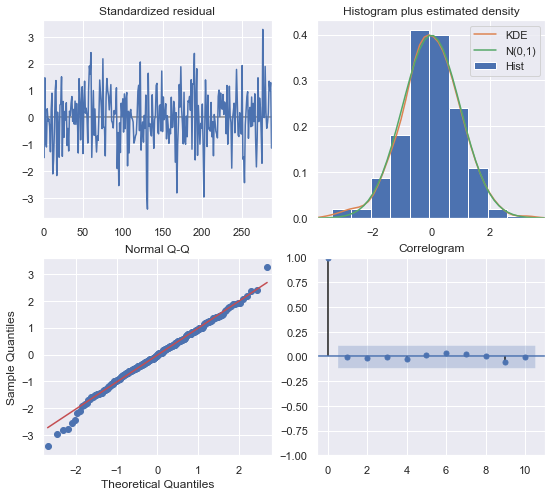

In [16]:
# Draw the plot_diagnostics of the results for Min temp series
pg.plotDiag(modelH.modelMin, figsize=(9,8))

matplotlib.figure.Figure

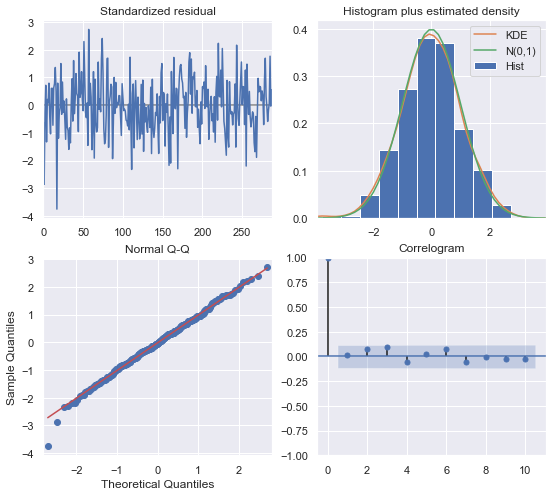

In [17]:
# Draw the plot_diagnostics of the results for Max temp series
pg.plotDiag(modelH.modelMax, figsize=(9,8))

* **Models fit, forecast and scoring**

Models fitted, making forecast...
Forecast completed, plotting results...

Min. Temp forecast MAE --> 0.9972
Max. Temp forecast MAE --> 1.4293




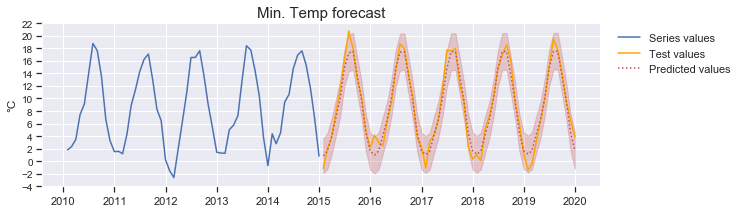

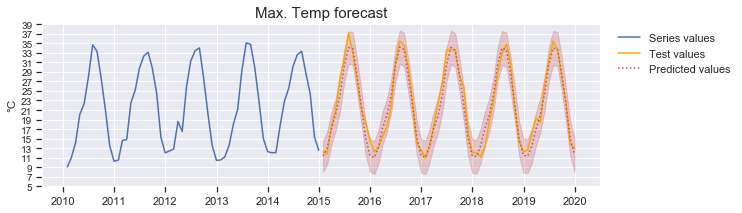

In [18]:
# Fit models, make forecast, print MAE and plot results.
fct, CI = modelH.fitForecast(modelH.modelMin, modelH.modelMax, data.minTrain, data.maxTrain,
                             data.minTest, data.maxTest, data.lstName)
fig1 = plt.figure(figsize=[10,3])
pg.plotForecast(data.minTrain.loc['2010-01':], data.minTest, fct[0], CI[0], fig1, '', '°C',
                data.lstName[0]+' forecast',lineW=1.5)
fig2 = plt.figure(figsize=[10,3])
pg.plotForecast(data.maxTrain.loc['2010-01':], data.maxTest, fct[1], CI[1], fig2, '', '°C',
                data.lstName[1]+' forecast',lineW=1.5)
plt.show()

* **Future predictions**

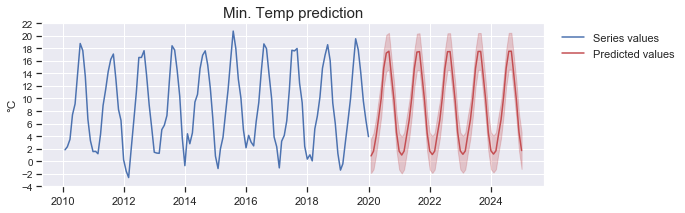

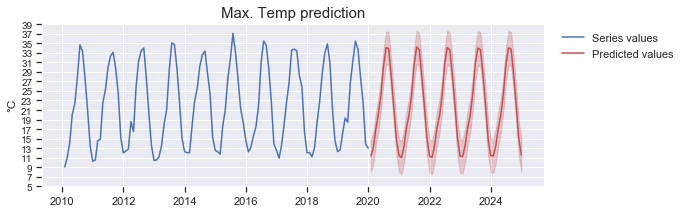

In [19]:
# Make predictions
date_rng = pd.date_range(start='1/1/2020', end='1/01/2025', freq='M')
minPred, minCI = modelH.predictConfInt(modelH.modelMin, date_rng, 'tmin')
maxPred, maxCI = modelH.predictConfInt(modelH.modelMax, date_rng, 'tmax')
fig1 = plt.figure(figsize=[9,3])
pg.plotPred(data.minDF.loc['2010-01':], minPred, minCI, fig1, '', '°C',
                data.lstName[0]+' prediction', lineW=1.5)
fig2 = plt.figure(figsize=[9,3])
pg.plotPred(data.maxDF.loc['2010-01':], maxPred, maxCI, fig2, '', '°C',
                data.lstName[1]+' prediction', lineW=1.5)

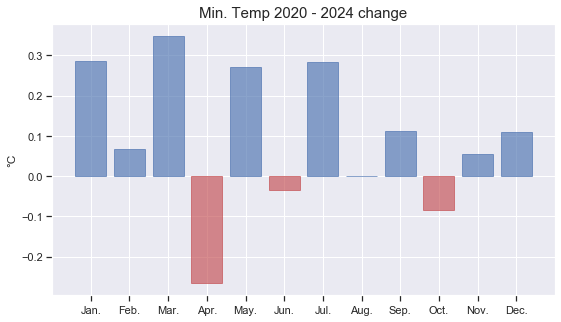

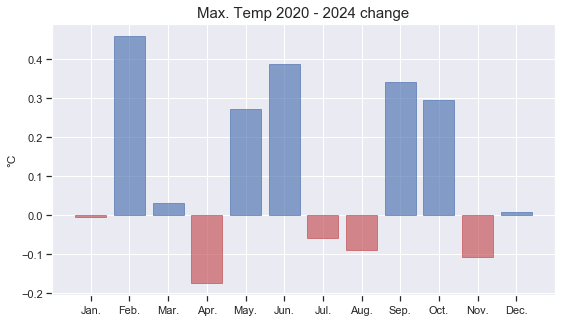

In [44]:
# Calculate change between first and last predicted year and plot results 
diffDF = modelH.predChange([minPred, maxPred], ['tmin', 'tmax'], ['minDiff', 'maxDiff'])
strTitle = ' 2020 - 2024 change'
fig1 = plt.figure(figsize=[9,5])
pg.plotBar(diffDF.index, diffDF['minDiff'], fig1, 0.8, data.lstName[0] + strTitle, '°C')
fig2 = plt.figure(figsize=[9,5])
pg.plotBar(diffDF.index, diffDF['maxDiff'], fig2, 0.8, data.lstName[1] + strTitle, '°C')
plt.show()